In [1]:
%matplotlib inline
import pickle
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from lrhp.neumann import TruncatedNeumannEstimator

In [2]:
df = pd.read_pickle("../data/fx_data.pkl")
with open("../data/fx_labels", "rb") as fp:
    labels = pickle.load(fp)

In [3]:
t = np.asarray(df.iloc[1:, 1] - df.iloc[0, 1], dtype=float)

train_end = 1_000_000
val_end = 1_300_000

t /= 100  # rescale for better numeric performance

t2 = t[train_end:val_end] - t[train_end]
t1 = t[:train_end]

c1 = np.asarray(df.iloc[:train_end, 0])
c2 = np.asarray(df.iloc[train_end:val_end, 0])

In [4]:
neumann = TruncatedNeumannEstimator(rank=10, is_nmf=True)

In [5]:
%%time
W, loss = neumann.fit(t1, c1, num_epochs=int(5e4), learning_rate=5e-4)

/Users/atturkm/VENVS/gluonts/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
100%|██████████| 50000/50000 [01:15<00:00, 659.11it/s, Loss=0.40377212]


CPU times: user 1min 21s, sys: 18.7 s, total: 1min 40s
Wall time: 1min 17s


In [6]:
Phi_neumann = np.clip(W.T.dot(W), a_min=0, a_max=None).astype(np.float64)

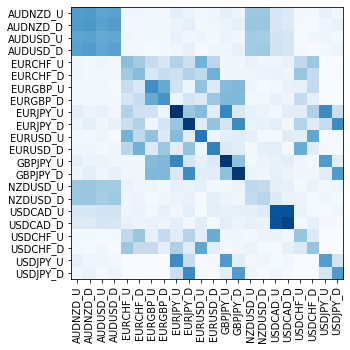

In [8]:
f, ax = plt.subplots(figsize=(6, 6))
ax.imshow(Phi_neumann, cmap="Blues")
ax.set(xticks=range(22), yticks=range(22), yticklabels=labels)
ax.set_xticklabels(labels, rotation="vertical")
plt.margins(0.3)
plt.subplots_adjust(bottom=0.25);

### Cluster 

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA

In [10]:
# nmf = NMF(n_components=2)
decomp = PCA(n_components=2, )
Wlr = decomp.fit_transform(W.T)

In [11]:
km = KMeans(n_clusters=5)
clus = km.fit_predict(W.T)

In [12]:
for i in range(km.n_clusters):
    assets = [a for j, a in enumerate(labels) if clus[j] == i]
    print(f"Cluster {i}: {' '.join(assets)}")

Cluster 0: EURCHF_U EURCHF_D EURGBP_U EURGBP_D EURUSD_U EURUSD_D USDCHF_U USDCHF_D
Cluster 1: AUDNZD_U AUDNZD_D AUDUSD_U AUDUSD_D NZDUSD_U NZDUSD_D
Cluster 2: EURJPY_D GBPJPY_D USDJPY_D
Cluster 3: EURJPY_U GBPJPY_U USDJPY_U
Cluster 4: USDCAD_U USDCAD_D


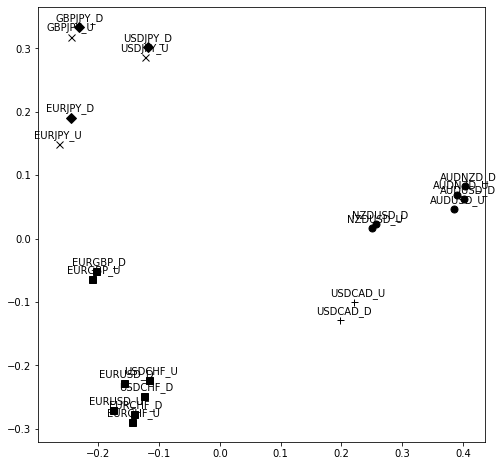

In [14]:
f, ax = plt.subplots(figsize=(8,8))

markers = ["s", "o", "D", "x", "+"]

for i, (point, clid) in enumerate(zip(Wlr, clus)):
    ax.plot(*point, markers[clid], color="k", markersize=7)
    ax.text(point[0]-0.04, point[1]+0.01, labels[i])